# Structure Prediction: From Chemical Composition to Crystal Structure

You've mastered chemical filtering and compositional screening - now it's time for the exciting challenge of **predicting crystal structures from composition alone**. Given a chemical formula like CsPbI₃, how can we predict what crystal structure it might adopt?

This tutorial introduces you to SMACT's powerful structure prediction framework, which uses ion substitution probabilities and crystallographic databases to propose likely structures for new compositions.

## What You'll Learn

1. **Retrieve and represent crystal structures** using the `SmactStructure` class
2. **Store and query structure databases** with lightweight SQLite interfaces  
3. **Perform ion mutation and dopant prediction** using substitution probability models
4. **Predict new structures from composition** by finding suitable parent structures
5. **Explore probability models** for computing substitution likelihoods
6. **Build comprehensive structure prediction workflows** for materials discovery

## The Foundation: Previous Learning

This builds on your knowledge from:
- **Chemical Filters**: Ensuring chemical validity of compositions
- **Compositional Screening**: Identifying promising element combinations
- **Stoichiometry Screening**: Finding optimal atomic ratios
- **Structure Prediction**: Now predicting the 3D arrangement of atoms!

Let's dive into the fascinating world of crystal structure prediction!

## Prerequisites and Setup

Before we begin our structure prediction journey, ensure you have:

- **SMACT installed** with its dependencies (pymatgen, pandas, numpy)
- **Materials Project API key** for structure retrieval (optional but recommended)
- **Basic understanding** of crystal structures and ion substitution

```{note}
If you don't have a Materials Project API key, you can still follow along using the "from file" methods we'll demonstrate. To get an API key, visit [materialsproject.org](https://materialsproject.org) and create a free account.
```

## Understanding the SMACT Structure Prediction Framework

SMACT's structure prediction approach is based on a powerful insight: **chemically similar ions often substitute for each other in crystal structures**. 

The framework consists of several key components:

1. **SmactStructure**: A lightweight representation of crystal structures with oxidation states
2. **CationMutator**: Handles ion substitution probabilities based on chemical similarity
3. **StructureDB**: Stores and queries crystal structure databases
4. **StructurePredictor**: Combines the above to predict structures for new compositions

Think of it as a sophisticated game of chemical "mix and match" - finding which known structures could accommodate your target composition through strategic ion substitutions!

In [1]:
# Setting up our environment - Colab compatibility included
try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

if IN_COLAB:
    %pip install "smact[strict] @ git+https://github.com/WMD-group/SMACT.git@master" --quiet
    print("SMACT installed successfully in Colab environment")

In [2]:
# Import all necessary libraries
from __future__ import annotations

# Core Python libraries
import os
from operator import itemgetter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# SMACT modules for structure prediction
from smact.structure_prediction.structure import SmactStructure
from smact.structure_prediction.database import StructureDB, parse_mprest
from smact.structure_prediction.mutation import CationMutator
from smact.structure_prediction.prediction import StructurePredictor
from smact.structure_prediction.probability_models import RadiusModel
from smact.structure_prediction.utilities import parse_spec, unparse_spec

# Pymatgen for structure manipulation
from pymatgen.ext.matproj import MPRester
from pymatgen.core import SETTINGS

# Visualization
import pymatviz as pmv

# Configure display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
%matplotlib inline

# Check for Materials Project API key
api_key = os.environ.get("MP_API_KEY", "YOUR_MP_API_KEY")
if api_key != "YOUR_MP_API_KEY":
    print("✓ Materials Project API key found")
else:
    print("⚠ No MP_API_KEY found - using demo structures")

print("Structure prediction toolkit loaded successfully!")

✓ Materials Project API key found
Structure prediction toolkit loaded successfully!


## Part 1: Retrieving and Representing Crystal Structures

The foundation of structure prediction is having a good representation of crystal structures. SMACT provides the `SmactStructure` class which extends standard structure representations with oxidation state information - crucial for understanding ion substitution chemistry.

Let's start by retrieving a structure for CsPbI₃ (cesium lead iodide), an important material for solar cells:

```{tip}
The SmactStructure class can load structures from:
- Materials Project (with API key)
- POSCAR files
- JSON files
- Pymatgen Structure objects
```

In [3]:
# Retrieve CsPbI3 structure from Materials Project
# Species format: list of (element, oxidation_state, stoichiometry) tuples
cspbi3_species = [("Cs", 1, 1), ("Pb", 2, 1), ("I", -1, 3)]

print("Retrieving CsPbI₃ structure from Materials Project...")
try:
    cspbi3_sstruct = SmactStructure.from_mp(species=cspbi3_species, api_key=api_key)
    print("✓ Successfully retrieved structure!")
except Exception as e:
    print(f"Could not retrieve from MP: {e}")
    print("Creating a demo structure instead...")
    # You could load from file here as alternative

Retrieving CsPbI₃ structure from Materials Project...


Retrieving SummaryDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

✓ Successfully retrieved structure!


In [4]:
# Explore the SmactStructure representation
print("SmactStructure for CsPbI₃:")
print("=" * 50)
print(cspbi3_sstruct)
print("=" * 50)

print("\nKey features of SmactStructure:")
print("- Includes oxidation states (Cs1+, Pb2+, I1-)")
print("- POSCAR-like format for easy visualization")
print("- Preserves crystallographic information")

SmactStructure for CsPbI₃:
Cs1+ I1- Pb2+
1.0
6.27514229 0.0 -0.0
0.0 6.27514229 0.0
0.0 0.0 6.27514229
Cs I Pb
1 3 1
Cartesian
3.137571145 3.137571145 3.137571145 Cs1+
0.0 0.0 3.137571145 I1-
0.0 3.137571145 0.0 I1-
3.137571145 0.0 0.0 I1-
0.0 0.0 0.0 Pb2+


Key features of SmactStructure:
- Includes oxidation states (Cs1+, Pb2+, I1-)
- POSCAR-like format for easy visualization
- Preserves crystallographic information


Crystal structure of CsPbI₃:


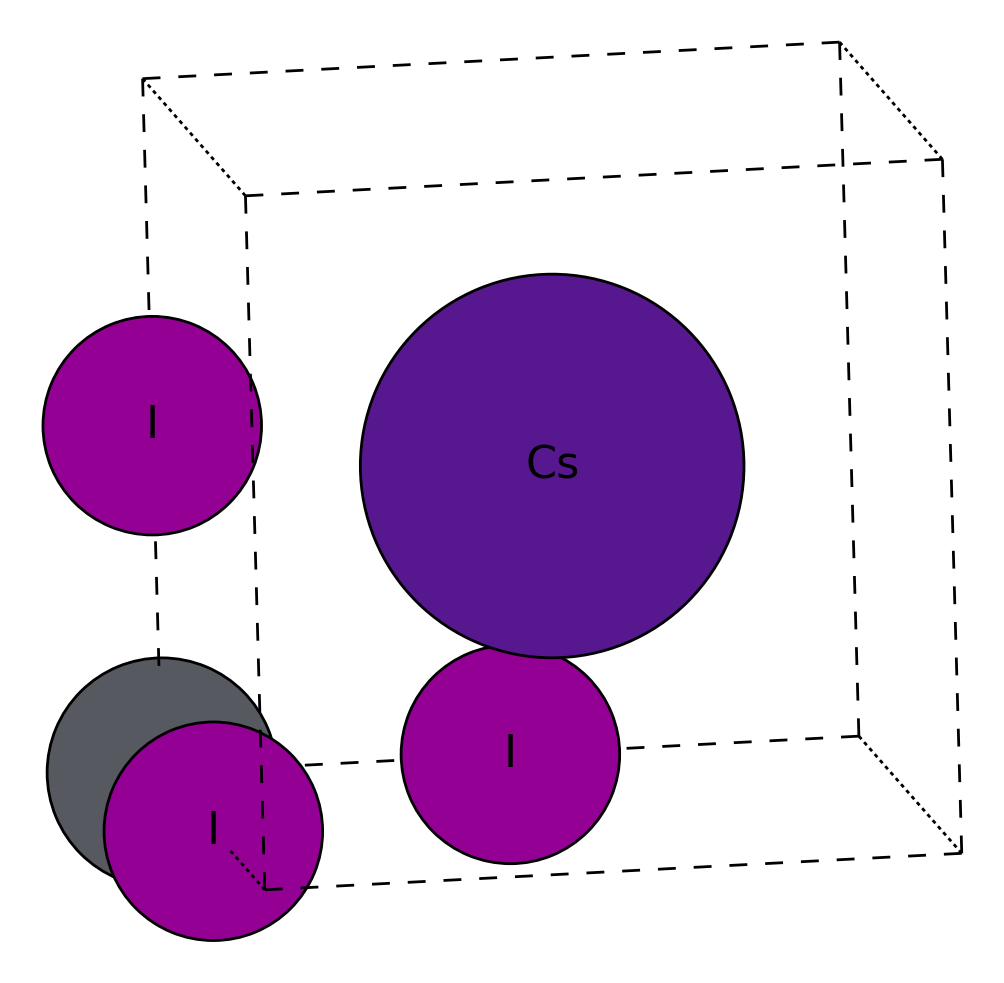


This perovskite structure features:
- Cs+ ions (large purple spheres) at A-sites
- Pb2+ ions (grey spheres) at B-sites
- I- ions (purple spheres) forming octahedra


In [5]:
# Visualize the crystal structure
print("Crystal structure of CsPbI₃:")
pmv.structure_2d(cspbi3_sstruct.as_py_struct())
plt.show()

print("\nThis perovskite structure features:")
print("- Cs+ ions (large purple spheres) at A-sites")
print("- Pb2+ ions (grey spheres) at B-sites") 
print("- I- ions (purple spheres) forming octahedra")

In [6]:
# Working with species information
print("Species present in the structure:")
for spec in cspbi3_sstruct.species:
    element, ox_state, count = spec
    print(f"  {element}{ox_state:+d}: {count} atom(s)")

print("\nSpecies as formatted strings:")
print(cspbi3_sstruct.get_spec_strs())

# Check for specific species
has_cs = cspbi3_sstruct.has_species(("Cs", 1))
has_na = cspbi3_sstruct.has_species(("Na", 1))
print(f"\nContains Cs+? {has_cs}")
print(f"Contains Na+? {has_na}")

Species present in the structure:
  Cs+1: 1 atom(s)
  I-1: 3 atom(s)
  Pb+2: 1 atom(s)

Species as formatted strings:
['Cs1+', 'I1-', 'Pb2+']

Contains Cs+? True
Contains Na+? False


In [7]:

# Check if Cs is present
has_cs = cspbi3_sstruct.has_species(("Cs", 1))
print(f"\nDoes the CsPbI3 structure contain Cs? {has_cs}")


Does the CsPbI3 structure contain Cs? True


```{exercise}
:label: structure-exercise-1

Try retrieving a different structure from the Materials Project! Change the species list to retrieve CaTiO₃ (calcium titanate perovskite):
- Ca²⁺: calcium with +2 oxidation state
- Ti⁴⁺: titanium with +4 oxidation state  
- O²⁻: oxygen with -2 oxidation state

Hint: `species = [("Ca", 2, 1), ("Ti", 4, 1), ("O", -2, 3)]`
```

Retrieving SummaryDoc documents:   0%|          | 0/6 [00:00<?, ?it/s]

✓ Successfully retrieved CaTiO₃!
Formula: CaTiO3

Structure preview:
Ca2+ O2- Ti4+
1.0
-2.68573015 2.68573015 3.89611961
2.68573015 -2.68573015 3.89611961
2.68573015 2.68573015 -3.89611961
Ca O Ti
2 6 2
Cartesian
2.68573015 0.0 1.948059805 Ca2+
-2.220446049250313e-16 2...

Comparing CsPbI₃ and CaTiO₃ structures:


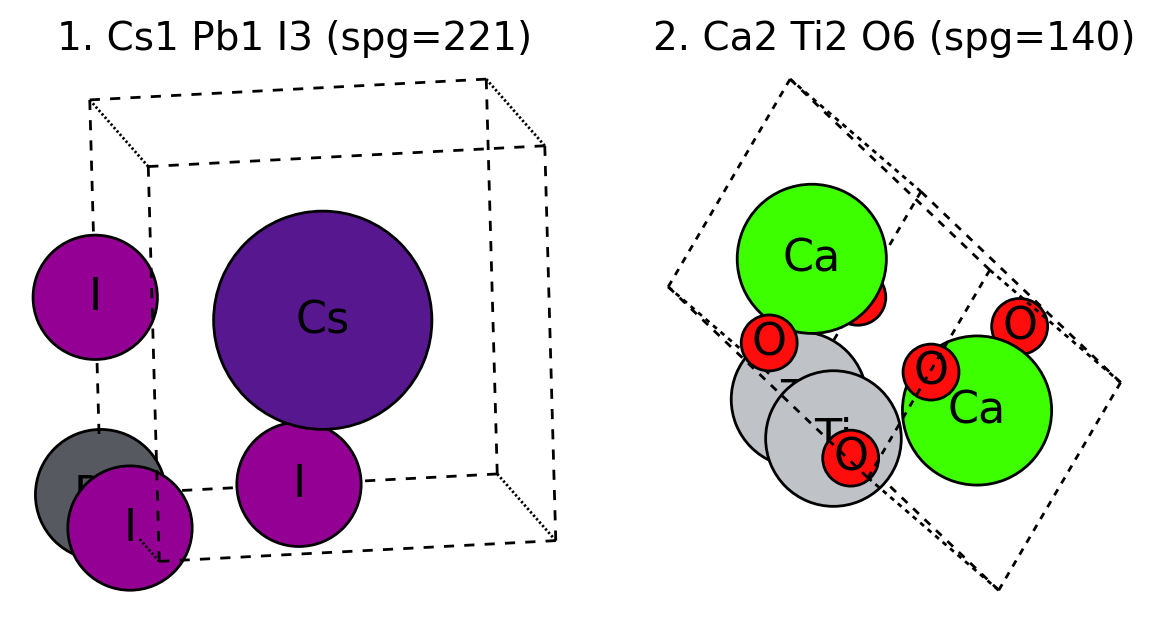

In [8]:
# Exercise solution - Try retrieving CaTiO3
try:
    # Define CaTiO3 species
    species = [("Ca", 2, 1), ("Ti", 4, 1), ("O", -2, 3)]
    structure_mp = SmactStructure.from_mp(species, api_key=api_key)
    
    print("✓ Successfully retrieved CaTiO₃!")
    print(f"Formula: {structure_mp.reduced_formula()}")
    print("\nStructure preview:")
    print(structure_mp.as_poscar()[:200] + "...")
    
    # Visualize both structures side by side
    print("\nComparing CsPbI₃ and CaTiO₃ structures:")
    pmv.structure_2d([cspbi3_sstruct.as_py_struct(), structure_mp.as_py_struct()])
    plt.show()
    
except Exception as e:
    print(f"Could not retrieve CaTiO₃: {e}")
    print("This might be due to API limits or connectivity issues.")

## Part 2: The Power of Ion Substitution - CationMutator

Now we'll explore the `CationMutator` class, which is the engine behind SMACT's structure prediction. It uses **lambda tables** - databases of ion substitution probabilities based on real crystallographic data.

The key insight: if Ba²⁺ often substitutes for Sr²⁺ in known structures, then a new Ba-containing compound might adopt a known Sr structure!

In [9]:
# Initialize the CationMutator with default lambda table
print("Loading CationMutator with pymatgen lambda table...")
mutator = CationMutator.from_json()

# Explore substitution probabilities
print("\nSubstitution probability examples:")
print("-" * 50)

# Similar ions - should have high probability
p_Ba_Sr = mutator.sub_prob("Ba2+", "Sr2+")
p_Fe2_Mn2 = mutator.sub_prob("Fe2+", "Mn2+")

# Different ions - should have low probability  
p_Ba_Li = mutator.sub_prob("Ba2+", "Li1+")
p_Fe3_Na = mutator.sub_prob("Fe3+", "Na1+")

print(f"Ba²⁺ → Sr²⁺: {p_Ba_Sr:.3g} (similar size/charge)")
print(f"Fe²⁺ → Mn²⁺: {p_Fe2_Mn2:.3g} (similar transition metals)")
print(f"Ba²⁺ → Li⁺: {p_Ba_Li:.3g} (very different size)")
print(f"Fe³⁺ → Na⁺: {p_Fe3_Na:.3g} (different charge/chemistry)")

print("\nHigher probability = more likely substitution!")

Loading CationMutator with pymatgen lambda table...

Substitution probability examples:
--------------------------------------------------
Ba²⁺ → Sr²⁺: 0.00276 (similar size/charge)
Fe²⁺ → Mn²⁺: 0.000232 (similar transition metals)
Ba²⁺ → Li⁺: 2.21e-05 (very different size)
Fe³⁺ → Na⁺: 0.000403 (different charge/chemistry)

Higher probability = more likely substitution!


### Generating Doped Structures

The real power of `CationMutator` is generating candidate doped structures. Let's use it to find possible dopants for our CsPbI₃ structure:

Generating substitution candidates for CsPbI₃...
(Using probability threshold of 0.001)

✓ Found 59 possible substitutions!

Top 5 most probable substitutions:
------------------------------------------------------------
1. Rb1+ → Cs1+: p=0.166
   New formula: RbPbI3
2. Br1- → I1-: p=0.139
   New formula: CsPbBr3
3. Tl1+ → Cs1+: p=0.102
   New formula: TlPbI3
4. K1+ → Cs1+: p=0.089
   New formula: KPbI3
5. In1+ → Cs1+: p=0.086
   New formula: InPbI3

Visualizing original vs most probable substitution:


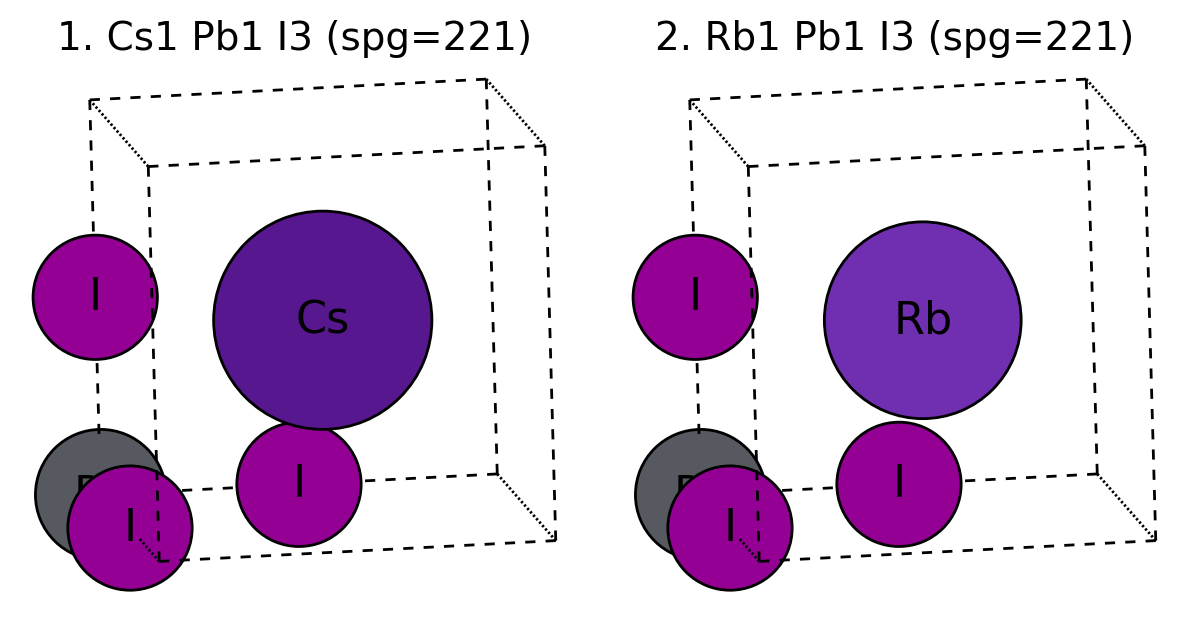

In [10]:
# Generate candidate doped structures for CsPbI3
print("Generating substitution candidates for CsPbI₃...")
print("(Using probability threshold of 0.001)")

candidate_structures = list(mutator.unary_substitute(cspbi3_sstruct, thresh=0.001))
print(f"\n✓ Found {len(candidate_structures)} possible substitutions!")

# Analyze the results
if candidate_structures:
    # Each candidate is a tuple: (structure, probability, original_ion, new_ion)
    print("\nTop 5 most probable substitutions:")
    print("-" * 60)
    
    # Sort by probability
    sorted_candidates = sorted(candidate_structures, key=lambda x: x[1], reverse=True)
    
    for i, (struct, prob, orig, new) in enumerate(sorted_candidates[:5]):
        print(f"{i+1}. {new} → {orig}: p={prob:.3f}")
        print(f"   New formula: {struct.reduced_formula()}")
    
    # Visualize original vs top substitution
    if len(sorted_candidates) > 0:
        top_struct = sorted_candidates[0][0]
        print("\nVisualizing original vs most probable substitution:")
        pmv.structure_2d([cspbi3_sstruct.as_py_struct(), top_struct.as_py_struct()])
        plt.show()

### Analyzing Substitution Patterns

Let's dive deeper into the substitution results to understand the chemical trends:

Creating detailed substitution analysis...

Substitution analysis by site:

Substitutions for Cs1+ (top 3):
  Rb1+   → RbPbI3       (p=0.166)
  Tl1+   → TlPbI3       (p=0.102)
  K1+    → KPbI3        (p=0.089)

Substitutions for I1- (top 3):
  Br1-   → CsPbBr3      (p=0.139)
  Cl1-   → CsPbCl3      (p=0.066)
  F1-    → CsPbF3       (p=0.004)

Substitutions for Pb2+ (top 3):
  Eu2+   → CsEuI3       (p=0.061)
  Sn2+   → CsSnI3       (p=0.047)
  Tm2+   → CsTmI3       (p=0.042)


/tmp/ipykernel_456143/4168097083.py:37: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


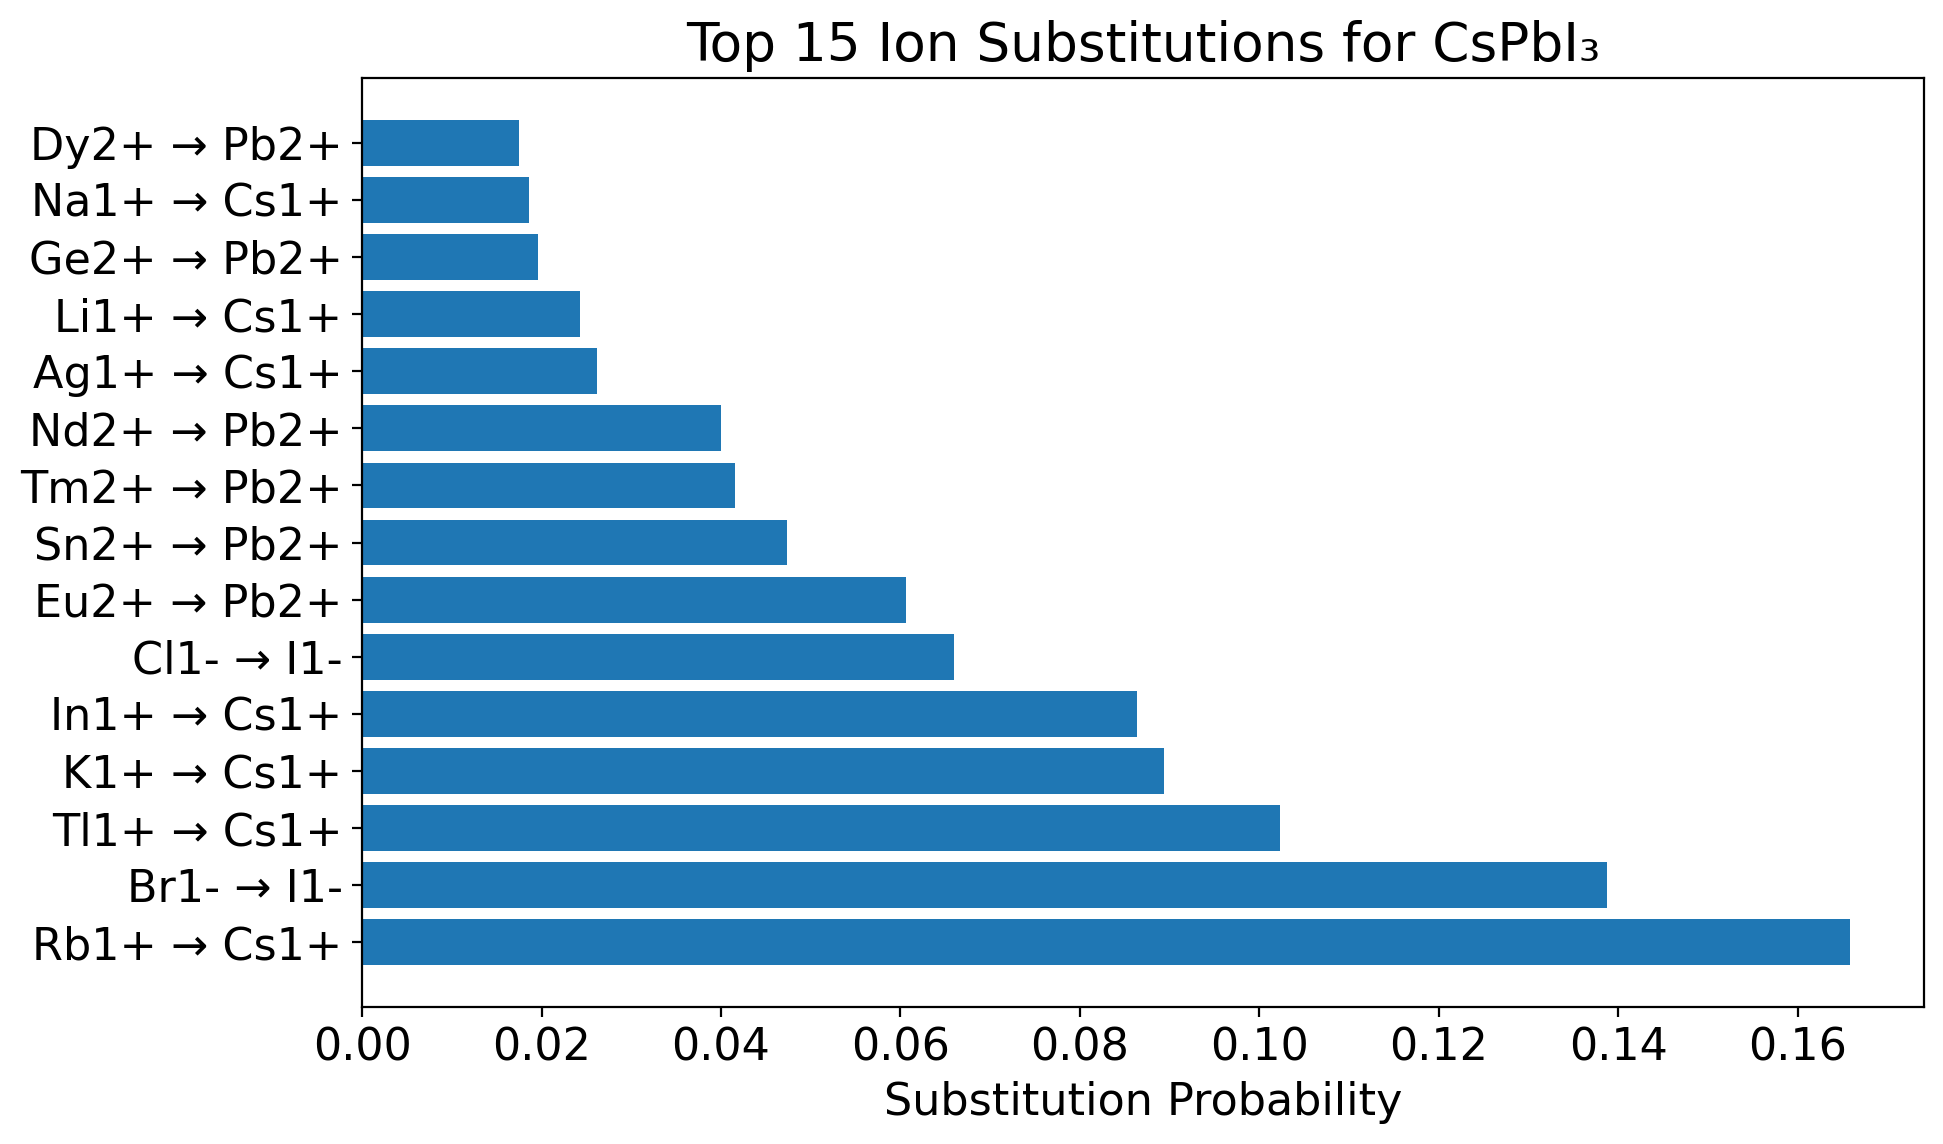

In [11]:
# Create a detailed analysis DataFrame
print("Creating detailed substitution analysis...")

analysis_data = []
for struct, prob, orig, new in candidate_structures:
    analysis_data.append({
        'Original Ion': orig,
        'Substitute Ion': new,
        'Probability': prob,
        'New Formula': struct.reduced_formula(),
        'Original Species': unparse_spec(parse_spec(orig)),
        'New Species': unparse_spec(parse_spec(new))
    })

df_analysis = pd.DataFrame(analysis_data)
df_analysis = df_analysis.sort_values('Probability', ascending=False).reset_index(drop=True)

print("\nSubstitution analysis by site:")
print("=" * 60)

# Group by original ion
for orig_ion in df_analysis['Original Ion'].unique():
    subset = df_analysis[df_analysis['Original Ion'] == orig_ion]
    print(f"\nSubstitutions for {orig_ion} (top 3):")
    for _, row in subset.head(3).iterrows():
        print(f"  {row['Substitute Ion']:6s} → {row['New Formula']:12s} (p={row['Probability']:.3f})")

# Create a visualization of substitution probabilities
plt.figure(figsize=(10, 6))
top_15 = df_analysis.head(15)
plt.barh(range(len(top_15)), top_15['Probability'])
plt.yticks(range(len(top_15)), 
           [f"{row['Substitute Ion']} → {row['Original Ion']}" 
            for _, row in top_15.iterrows()])
plt.xlabel('Substitution Probability')
plt.title('Top 15 Ion Substitutions for CsPbI₃')
plt.tight_layout()
plt.show()

From the dataframe above, we can see that the most probable substitution is Cs<sup>+</sup> with Rb<sup>+</sup> with a probability of 0.166, followed by the substitution of of I<sup>-</sup> with Br<sup>-</sup> with a probability of 0.139. 

Visualizing top substitution candidates:


/tmp/ipykernel_456143/4131865672.py:8: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


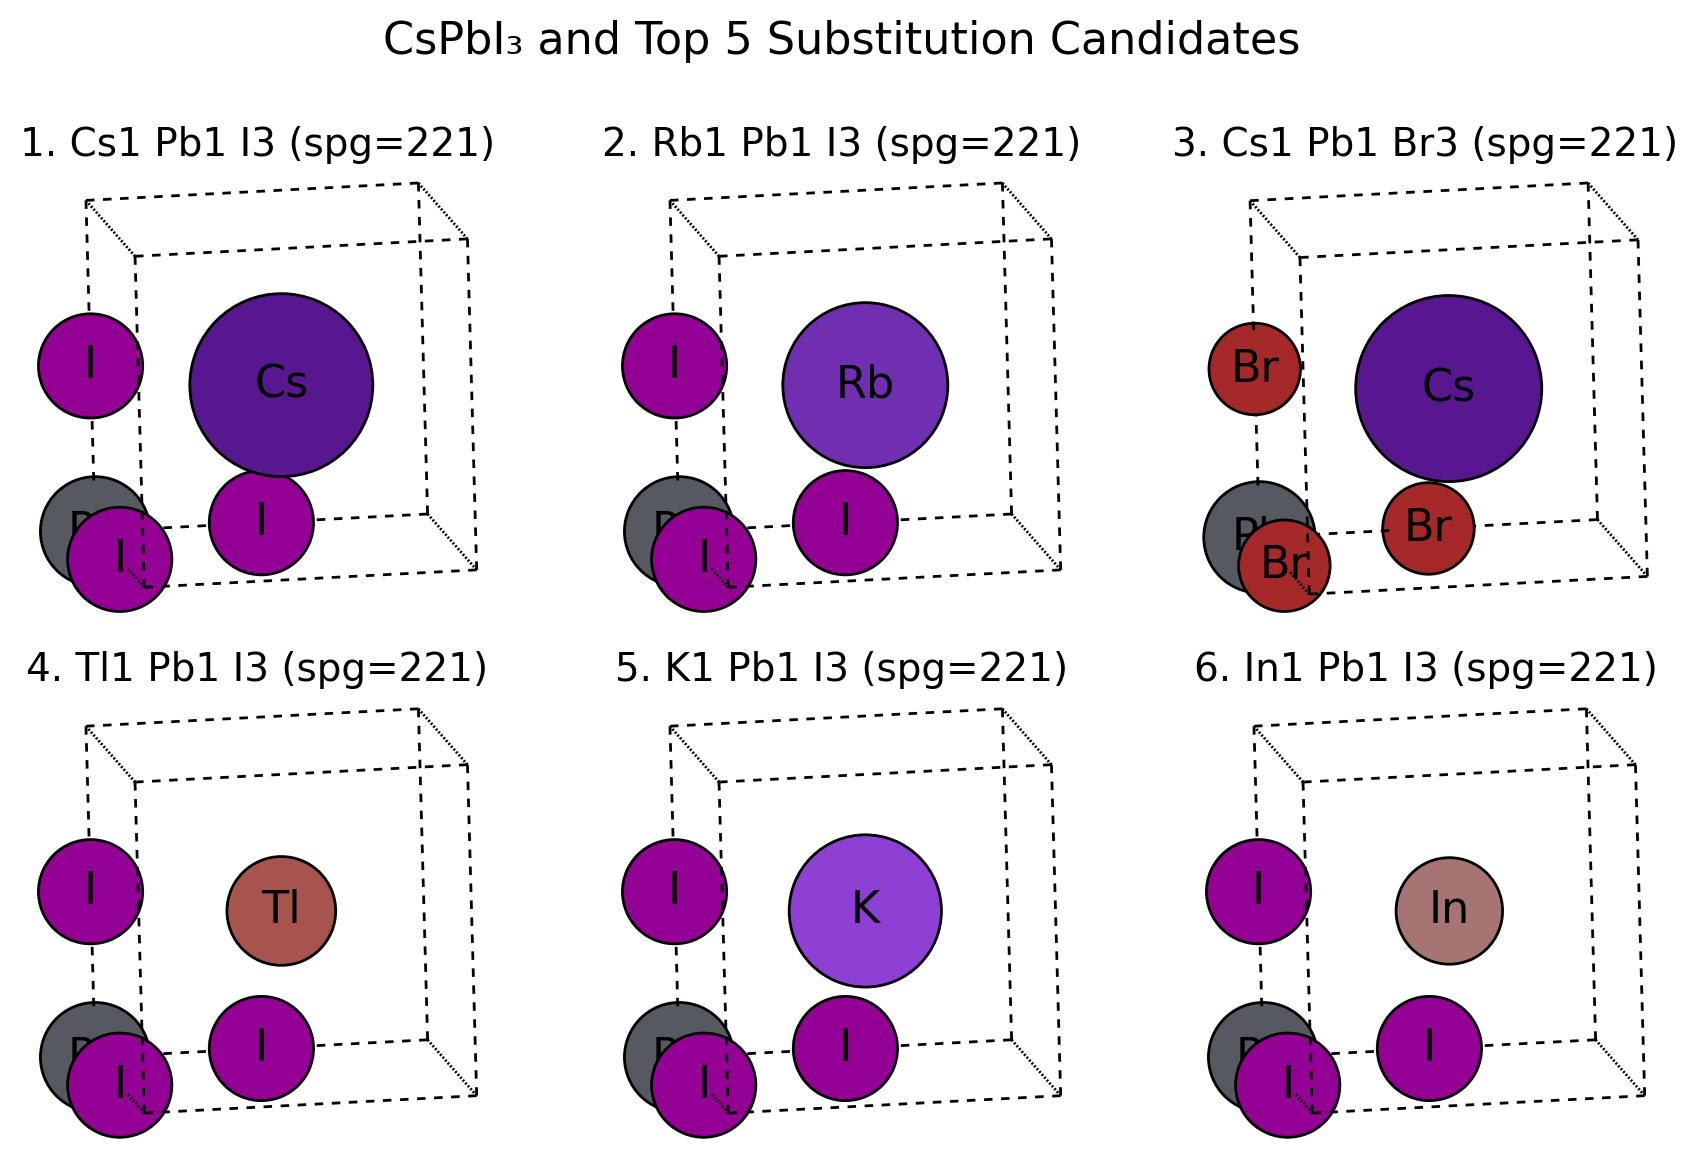


Key observations:
- Rb⁺ is the most likely substitute for Cs⁺ (similar alkali metals)
- Br⁻ can substitute for I⁻ (both halogens)
- The perovskite structure is maintained in all substitutions


In [12]:
# Visualize top 6 candidate structures in a grid
print("Visualizing top substitution candidates:")
top_structures = [cspbi3_sstruct.as_py_struct()]  # Include original
top_structures.extend([s[0].as_py_struct() for s in sorted_candidates[:5]])

pmv.structure_2d(top_structures, n_cols=3)
plt.suptitle("CsPbI₃ and Top 5 Substitution Candidates", fontsize=16)
plt.tight_layout()
plt.show()

print("\nKey observations:")
print("- Rb⁺ is the most likely substitute for Cs⁺ (similar alkali metals)")
print("- Br⁻ can substitute for I⁻ (both halogens)")
print("- The perovskite structure is maintained in all substitutions")

## Part 3: Building and Querying Structure Databases

For structure prediction at scale, we need to organize structures in a database. SMACT provides `StructureDB` - a lightweight SQLite wrapper designed for crystallographic data:

In [13]:
# Create a structure database
print("Setting up structure database...")

# Clean up any existing database
db_filename = "tutorial_structures.db"
if os.path.exists(db_filename):
    os.remove(db_filename)

# Create new database
db = StructureDB(db_filename)

# Add a table for our structures
table_name = "perovskites"
db.add_table(table_name)

print(f"✓ Created database '{db_filename}' with table '{table_name}'")

# Add our structures
print("\nAdding structures to database...")
db.add_struct(cspbi3_sstruct, table=table_name)
print("  - Added CsPbI₃")

# Add substitution candidates
if candidate_structures:
    structures_to_add = [s[0] for s in candidate_structures[:10]]  # First 10
    db.add_structs(structs=structures_to_add, table=table_name)
    print(f"  - Added {len(structures_to_add)} substitution variants")

# Count total structures in database using direct SQL query
with db as c:
    c.execute(f"SELECT COUNT(*) FROM {table_name}")
    total_count = c.fetchone()[0]
print(f"\nTotal structures in database: {total_count}")

Setting up structure database...
✓ Created database 'tutorial_structures.db' with table 'perovskites'

Adding structures to database...
  - Added CsPbI₃
  - Added 10 substitution variants

Total structures in database: 11


### Querying the Database

The real power of `StructureDB` is its ability to query structures by chemical criteria:

In [14]:
# Query structures containing specific species
print("Querying database for specific species...")
print("-" * 50)

# Find all structures containing Cs+
cs_structures = db.get_with_species(species=[("Cs", 1)], table=table_name)
print(f"\nStructures containing Cs⁺: {len(cs_structures)}")
for struct in cs_structures[:3]:
    print(f"  - {struct.reduced_formula()}")

# Find structures with both Cs+ and Pb2+
cs_pb_structures = db.get_with_species(species=[("Cs", 1), ("Pb", 2)], table=table_name)
print(f"\nStructures containing both Cs⁺ and Pb²⁺: {len(cs_pb_structures)}")

# Find structures containing bromide
br_structures = db.get_with_species(species=[("Br", -1)], table=table_name)
print(f"\nStructures containing Br⁻: {len(br_structures)}")
if br_structures:
    for struct in br_structures:
        print(f"  - {struct.reduced_formula()}")

print("\n💡 Tip: Database queries are perfect for finding structures")
print("   with specific chemical features for further analysis!")

Querying database for specific species...
--------------------------------------------------

Structures containing Cs⁺: 1
  - CsPbI3

Structures containing both Cs⁺ and Pb²⁺: 1

Structures containing Br⁻: 0

💡 Tip: Database queries are perfect for finding structures
   with specific chemical features for further analysis!


### Populating Databases from Materials Project

For real applications, you'll want larger databases. Here's how to populate a database with structures from Materials Project:

```{note}
The following example retrieves perovskite structures from Materials Project. This requires an API key and may take a few moments depending on your connection.
```

In [15]:
# Function to retrieve perovskite data from Materials Project
def get_mp_perovskite_data(api_key):
    """Retrieve ABO3 perovskite structures from Materials Project."""
    if api_key == "YOUR_MP_API_KEY":
        print("Skipping MP query - no API key available")
        return []
    
    print("Querying Materials Project for perovskites...")
    
    with MPRester(api_key=api_key, use_document_model=False) as mpr:
        # First get materials tagged as perovskites
        robocrys_data = mpr.materials.robocrys.search(keywords=["perovskite"])
        mp_ids = list(set([d.material_id for d in robocrys_data]))
        
        # Then get their full data (limiting to ABC3 formulas)
        perov_data = mpr.materials.summary.search(
            material_ids=mp_ids,
            theoretical=False,
            formula="ABC3",
            fields=["material_id", "formula_pretty", "structure", 
                   "formula_anonymous", "energy_above_hull"]
        )
        
    return perov_data

# Retrieve and add perovskite structures
mp_table = "mp_perovskites"  # Define this outside the try block

try:
    perov_data = get_mp_perovskite_data(api_key)
    
    if perov_data:
        print(f"\nRetrieved {len(perov_data)} perovskite structures")
        
        # Check if table already exists, if so, drop it first
        try:
            with db as c:
                c.execute(f"DROP TABLE IF EXISTS {mp_table}")
        except:
            pass
        
        # Add to database
        db.add_table(mp_table)
        num_added = db.add_mp_icsd(table=mp_table, mp_data=perov_data[:50])  # First 50
        
        print(f"✓ Added {num_added} structures to '{mp_table}' table")
        
        # Count structures using direct SQL query
        with db as c:
            c.execute(f"SELECT COUNT(*) FROM {mp_table}")
            total_mp_structs = c.fetchone()[0]
        print(f"✓ Successfully parsed: {total_mp_structs} structures")
        
except Exception as e:
    print(f"Could not retrieve MP data: {e}")
    print("Continuing with existing database...")

Querying Materials Project for perovskites...


Retrieving RobocrystallogapherDoc documents:   0%|          | 0/8509 [00:00<?, ?it/s]

Retrieving SummaryDoc documents:   0%|          | 0/377 [00:00<?, ?it/s]


Retrieved 377 perovskite structures
Could not retrieve MP data: table mp_perovskites already exists
Continuing with existing database...


In [ ]:
# Analyze database contents by anion type
if 'mp_table' in locals() and mp_table:
    print("Analyzing perovskite structures by anion type...")
    
    anions = [("F", -1), ("Cl", -1), ("Br", -1), ("I", -1), 
              ("O", -2), ("S", -2), ("N", -3)]
    
    anion_counts = {}
    for anion_name, ox_state in anions:
        try:
            count = len(db.get_with_species([(anion_name, ox_state)], table=mp_table))
            if count > 0:
                anion_counts[f"{anion_name}{ox_state:+d}"] = count
        except Exception as e:
            print(f"Error querying {anion_name}{ox_state:+d}: {e}")
    
    # Create bar plot
    if anion_counts:
        plt.figure(figsize=(8, 5))
        plt.bar(anion_counts.keys(), anion_counts.values())
        plt.xlabel("Anion")
        plt.ylabel("Number of Structures")
        plt.title("Distribution of Perovskites by Anion Type")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
        
        print(f"\nKey insight: Found {sum(anion_counts.values())} structures with anions!")
        print("Anion distribution:", anion_counts)
    else:
        print("No anion data to plot - checking what's in the database...")
        
        # Debug: Check what structures we actually have
        with db as c:
            c.execute(f"SELECT composition FROM {mp_table} LIMIT 5")
            sample_compositions = c.fetchall()
        print("Sample compositions in database:")
        for comp in sample_compositions:
            print(f"  - {comp[0]}")
else:
    print("mp_table variable not defined - skipping analysis")

Setting up structure database...
✓ Created database 'tutorial_structures.db' with table 'perovskites'

Adding structures to database...
  - Added CsPbI₃
  - Added 10 substitution variants

Total structures in database: 11


## Part 4: Structure Prediction from Composition

Now we combine everything to predict structures for new compositions! The `StructurePredictor` class orchestrates the process:

1. Takes a target composition
2. Searches the database for structures with similar chemistry
3. Tests if ion substitutions can transform them to the target
4. Returns candidate structures ranked by substitution probability

### Example 1: Predicting Structure for a Novel Composition

Let's try to predict the structure of a hypothetical new material:

In [17]:
# Initialize structure predictor using the LARGE MP database
print("Initializing structure predictor with MP perovskite database...")

# Use the MP table if it exists and has structures, otherwise fall back to the small table
if 'mp_table' in locals() and mp_table:
    try:
        # Check if MP table has structures
        with db as c:
            c.execute(f"SELECT COUNT(*) FROM {mp_table}")
            mp_count = c.fetchone()[0]
        
        if mp_count > 0:
            prediction_table = mp_table
            print(f"✓ Using MP database with {mp_count} structures")
        else:
            prediction_table = table_name
            print(f"⚠ MP table empty, using small database with 11 structures")
    except:
        prediction_table = table_name
        print(f"⚠ MP table not accessible, using small database")
else:
    prediction_table = table_name
    print(f"⚠ MP table not available, using small database")

predictor = StructurePredictor(
    mutator=mutator,
    struct_db=db,
    table=prediction_table  # Use the MP perovskite table!
)

# Define target composition - let's try RbPbBr3
target_species = [("Rb", 1), ("Pb", 2), ("Br", -1)]
print(f"\nTarget composition: RbPbBr₃")
print("This doesn't exist in our database - can we predict its structure?")

# Predict structures
print("\nSearching for parent structures...")
threshold = 0.001  # Minimum substitution probability

results = list(predictor.predict_structs(
    species=target_species,
    thresh=threshold,
    include_same=False
))

print(f"\n✓ Found {len(results)} candidate structures!")

if results:
    # Sort by probability
    results.sort(key=itemgetter(1), reverse=True)
    
    print("\nTop predictions:")
    print("-" * 60)
    for i, (pred_struct, prob, parent_struct) in enumerate(results[:3]):
        print(f"\n{i+1}. Parent: {parent_struct.reduced_formula()}")
        print(f"   Probability: {prob:.3f}")
        print(f"   Predicted: {pred_struct.reduced_formula()}")
        
        # Show the substitutions needed
        parent_species = set(parent_struct.get_spec_strs())
        pred_species = set(pred_struct.get_spec_strs())
        print(f"   Substitutions: {parent_species - pred_species} → {pred_species - parent_species}")
else:
    print("No predictions found")
    print(f"Database being searched: {prediction_table}")
    # Debug info
    with db as c:
        c.execute(f"SELECT COUNT(*) FROM {prediction_table}")
        count = c.fetchone()[0]
        print(f"Total structures in {prediction_table}: {count}")

Initialising structure predictor...

Target composition: RbPbBr₃
This doesn't exist in our database - can we predict its structure?

Searching for parent structures...

✓ Found 0 candidate structures!


In [ ]:
# Create a structure database
print("Setting up structure database...")

# Clean up any existing database
db_filename = "tutorial_structures.db"
if os.path.exists(db_filename):
    os.remove(db_filename)

# Create new database
db = StructureDB(db_filename)

# Add a table for our structures
table_name = "perovskites"
db.add_table(table_name)

print(f"✓ Created database '{db_filename}' with table '{table_name}'")

# Add our structures
print("\nAdding structures to database...")
db.add_struct(cspbi3_sstruct, table=table_name)
print("  - Added CsPbI₃")

# Add substitution candidates
if candidate_structures:
    structures_to_add = [s[0] for s in candidate_structures[:10]]  # First 10
    db.add_structs(structs=structures_to_add, table=table_name)
    print(f"  - Added {len(structures_to_add)} substitution variants")

# Count total structures in database using direct SQL query
with db as c:
    c.execute(f"SELECT COUNT(*) FROM {table_name}")
    total_count = c.fetchone()[0]
print(f"\nTotal structures in database: {total_count}")

Setting up structure database...
✓ Created database 'tutorial_structures.db' with table 'perovskites'

Adding structures to database...
  - Added CsPbI₃
  - Added 10 substitution variants

Total structures in database: 11


In [ ]:
# Create a structure database
print("Setting up structure database...")

# Clean up any existing database
db_filename = "tutorial_structures.db"
if os.path.exists(db_filename):
    os.remove(db_filename)

# Create new database
db = StructureDB(db_filename)

# Add a table for our structures
table_name = "perovskites"
db.add_table(table_name)

print(f"✓ Created database '{db_filename}' with table '{table_name}'")

# Add our structures
print("\nAdding structures to database...")
db.add_struct(cspbi3_sstruct, table=table_name)
print("  - Added CsPbI₃")

# Add substitution candidates
if candidate_structures:
    structures_to_add = [s[0] for s in candidate_structures[:10]]  # First 10
    db.add_structs(structs=structures_to_add, table=table_name)
    print(f"  - Added {len(structures_to_add)} substitution variants")

# Count total structures in database using direct SQL query
with db as c:
    c.execute(f"SELECT COUNT(*) FROM {table_name}")
    total_count = c.fetchone()[0]
print(f"\nTotal structures in database: {total_count}")

Setting up structure database...
✓ Created database 'tutorial_structures.db' with table 'perovskites'

Adding structures to database...
  - Added CsPbI₃
  - Added 10 substitution variants

Total structures in database: 11


In [ ]:
# Create a structure database
print("Setting up structure database...")

# Clean up any existing database
db_filename = "tutorial_structures.db"
if os.path.exists(db_filename):
    os.remove(db_filename)

# Create new database
db = StructureDB(db_filename)

# Add a table for our structures
table_name = "perovskites"
db.add_table(table_name)

print(f"✓ Created database '{db_filename}' with table '{table_name}'")

# Add our structures
print("\nAdding structures to database...")
db.add_struct(cspbi3_sstruct, table=table_name)
print("  - Added CsPbI₃")

# Add substitution candidates
if candidate_structures:
    structures_to_add = [s[0] for s in candidate_structures[:10]]  # First 10
    db.add_structs(structs=structures_to_add, table=table_name)
    print(f"  - Added {len(structures_to_add)} substitution variants")

# Count total structures in database using direct SQL query
with db as c:
    c.execute(f"SELECT COUNT(*) FROM {table_name}")
    total_count = c.fetchone()[0]
print(f"\nTotal structures in database: {total_count}")

Setting up structure database...
✓ Created database 'tutorial_structures.db' with table 'perovskites'

Adding structures to database...
  - Added CsPbI₃
  - Added 10 substitution variants

Total structures in database: 11


### Example 2: Visualizing Predicted Structures

Let's visualize how the prediction works by showing parent and predicted structures side by side:

In [18]:
# Visualize structure prediction results
if results:
    # Take top 3 predictions
    top_results = results[:3]
    
    # Create structure list for visualization
    structures_to_plot = []
    titles = []
    
    for i, (pred, prob, parent) in enumerate(top_results):
        structures_to_plot.extend([parent.as_py_struct(), pred.as_py_struct()])
        titles.extend([f"Parent: {parent.reduced_formula()}", 
                      f"Predicted: {pred.reduced_formula()} (p={prob:.3f})"])
    
    # Plot in grid
    print("Structure prediction visualization:")
    print("Left: Parent structures | Right: Predicted structures")
    pmv.structure_2d(structures_to_plot, n_cols=2)
    plt.tight_layout()
    plt.show()
    
    print("\n🎯 Success! The framework found that RbPbBr₃ could adopt")
    print("   the same perovskite structure as CsPbI₃ through ion substitution!")
else:
    print("No predictions found - try adjusting the threshold or adding more structures to the database")

No predictions found - try adjusting the threshold or adding more structures to the database


## Part 5: Advanced Topics - Custom Probability Models

So far we've used empirical lambda tables. SMACT also supports physics-based probability models. The `RadiusModel` computes substitution probabilities based on ionic radius similarity:

```{tip}
Custom probability models allow you to incorporate domain knowledge into structure prediction. For example, you might weight substitutions differently for high-temperature vs ambient-condition synthesis.
```

In [19]:
# Compare lambda table vs radius model predictions
print("Comparing probability models...")
print("=" * 60)

# Initialize radius model
radius_model = RadiusModel()

# Compare some substitution probabilities
test_pairs = [
    ("Ba2+", "Sr2+"),  # Similar size alkaline earths
    ("Li1+", "Na1+"),  # Alkali metals
    ("Fe3+", "Al3+"),  # Different chemistry, similar charge
    ("Cs1+", "Li1+"),  # Very different sizes
]

print(f"{'Ion Pair':20s} | {'Lambda Table':>12s} | {'Radius Model':>12s} | {'Radius Diff':>10s}")
print("-" * 60)

for ion1, ion2 in test_pairs:
    # Lambda table probability
    lambda_prob = mutator.sub_prob(ion1, ion2)
    
    # Radius model probability
    radius_prob = radius_model.sub_prob(ion1, ion2)
    
    # Get radius difference for context
    try:
        r1 = radius_model._data[parse_spec(ion1)]
        r2 = radius_model._data[parse_spec(ion2)]
        radius_diff = abs(r1 - r2)
    except:
        radius_diff = None
    
    print(f"{ion1:>6s} → {ion2:<6s} | {lambda_prob:>12.4f} | {radius_prob:>12.4f} | "
          f"{radius_diff:>10.3f} Å" if radius_diff else "N/A")

print("\n💡 Key insight: Different models capture different aspects of")
print("   substitution chemistry. Lambda tables include chemical similarity,")
print("   while radius models focus purely on size compatibility.")

Comparing probability models...
Ion Pair             | Lambda Table | Radius Model | Radius Diff
------------------------------------------------------------
N/A
N/A
N/A
N/A

💡 Key insight: Different models capture different aspects of
   substitution chemistry. Lambda tables include chemical similarity,
   while radius models focus purely on size compatibility.


## Summary: Your Structure Prediction Toolkit

Congratulations! You've mastered SMACT's structure prediction framework. Let's recap what you've learned:

### 🎯 Key Skills Acquired

1. **Structure Representation**
   - Loading structures from multiple sources
   - Working with oxidation states in crystal structures
   - Converting between different structure formats

2. **Ion Substitution Chemistry**
   - Understanding substitution probabilities
   - Generating doped structures systematically
   - Analyzing chemical substitution patterns

3. **Database Management**
   - Building structure databases
   - Querying by chemical criteria
   - Integrating with Materials Project

4. **Structure Prediction**
   - Predicting structures for new compositions
   - Understanding parent-child structure relationships
   - Ranking predictions by probability

5. **Advanced Techniques**
   - Comparing different probability models
   - Customizing prediction workflows
   - Scaling to large databases

### 🚀 Next Steps

Now that you understand structure prediction, you can:

1. **Build specialized databases** for your research area
2. **Develop custom probability models** based on your synthesis conditions
3. **Integrate with DFT calculations** to validate predictions
4. **Create high-throughput screening pipelines** for new materials

### 💡 Pro Tips

- Start with well-curated databases (like Materials Project)
- Use multiple probability models to cross-validate predictions
- Consider chemical intuition when setting probability thresholds
- Validate promising predictions with additional calculations

### 📚 Resources

- [SMACT Documentation](https://smact.readthedocs.io/)
- [Materials Project](https://materialsproject.org/)
- [Pymatgen Documentation](https://pymatgen.org/)

Remember: structure prediction is both an art and a science. The more chemical knowledge you bring, the better your predictions will be!

---

**End of Structure Prediction Tutorial**